# Introduction to Atmospheric Correction
### By Susan Meerdink<sup>1</sup>

<sup>1</sup>The Machine Learning and Sensing Lab, Electrical and Computer Engineering, University of Florida, Gainesville, FL 32611
<url>https://faculty.eng.ufl.edu/machine-learning/</url>

**Electromagnetic Spectrum Refresher**

* Term used to describe the entire range of light that exists. Generally for remote sensing imagery we work with the visible shortwave infrared (VSWIR) which ranges from 350 to 2500 nm. However, it can also apply to the thermal infrared (TIR) which ranges from 2500 nm to 15 um. Atmospheric correction can be applied to imagery measuring the VSWIR and TIR, but this introduction will focus on the VSWIR.
<img src="Picture01.png" alt="Electromagnetic Spectrum" style="width: 600px;"/>

**Remote Sensing Basics**

* Electromagnetic radiation is the dominant way evergy is transported from the sun to the earth. This energy passes from the sun through the atmosphere, where it is absorbed and reflected by particles/gasses/aerosols in the atmosphere. The energy then interacts with the earth's surface, also absorbing and reflecting biophysical and chemical properties of that surface. Energy is then reflected back through the atmosphere, where it is again influenced by atmopsheric components, to ultimately be measured by the sensor. 

NOTE: This is for passive remote sensing. Active remote sensing does not rely on the sun for energy, but generates its own energy source (e.g., lidar)
<img src="Picture02.png" alt="RS Basics" style="width: 600px;"/>

**Remote Sensing Data Pipeline**  
In remote sensing, imagery can be delivered in multiple products. This terminology can vary across sensors, but for Landsat they are referred to as Levels so you would have Level 1B, Level 2, Level 3. Depending on your research question, you would need a different product level although for terrestrial applications reflectance products are the most common. Below is an explanation of that product pipeline.

Each of the products below are shown with plot of three pixels extracted from the below hyperspectral image. 
<img src="Picture03.png" alt="RGB with Examples" style="width: 300px;"/>

* _Digitial Numbers (DNs)_: this data product is a quantized digital number of the amount of energy reflected from the surface and measured by a sensor. These values are sensor dependent and not useful for science because they are not physically meaning units. To convert from DNs to radiance, a gain and offset per band are applied to the data which are provided by the sensor designers or engineers.
    * Each pixel value is influenced by light source, system optical characteristics, detector characteristics, atmopsheric absorption, and surface properties.
<img src="Picture04.png" alt="DNs" style="width: 600px;"/>
* _Radiance_: this data product is the amount of radiation (or energy) per pixel which has the units of µW/(cm^2*sr*um) of W/(m^2*sr*um). This data product includes artifacts/noise from the atmosphere due to scattering and absorption. 
    * Each pixel value is influenced by light source, atmopsheric absorptions, and surface properties.
    * Note: Make sure to check the units of your imagery when doing atmopsheric corrections.
<img src="Picture05.png" alt="RDs" style="width: 600px;"/>
* _Reflectance_: this data product is the proportion of total radiation from the sun striking a surface and is reflected back to the sensor. The units of this product is 0 - 100% reflectance since it is a proportion to the total amount of radiation available. This data product is created AFTER atmospheric correction to remove any artifacts/noise from the atmospheric components. 
    * Each pixel value is influenced by surface properties. 
<img src="Picture06.png" alt="RDs" style="width: 600px;"/>

Notes:
* The above is assuming that we are interested in the surface of the earth. There are radiance and reflectance products for the Top-of-atmosphere (TOA) which is the amount of radiation or reflectance measured by a space-based sensor flying higher than the earth's atmosphere. These products include contributions of the atmopshere including clouds, atmopsheric aerosols, and gases. This is often done to avoid performing atmospheric correction since it can be a complicated, time consuming process.

**Atmospheric Components**  
In order to get from a radiance product to reflectance, the atmospheric components and their interaction with radiation needs to be quantified. But what are the components or factors that impact a remote sensing image?

1. Geometry Factors: These are often known factors that can be determined based on the sensor, date, and time of collection.
  * Solar Angle
  * Viewing Angle
  * Sensor Altitude
  * Target Altitude
2. Atmospheric Profile: Depending on the factor in this cateogory, it can be hard to model the atmospheric contribution. Abundances of well-mixed gasses are effectively constant, so they are easier to model given a time and location on Earth. However, water vapor concentrations are highly variable spatially, temporally, and vertically in the atmosphere. Often under or over estimation of water vapor concentrations yield the highest errors in retrieving reflectance. The atmospheric profile contains:
  * Water Vapor
  * Oxygen
  * Carbon dioxide
  * Carbon monoxide
  * Methane
  * Nitrous oxide
3. Aerosol Profile: These factors are often the hardest to estimate because they vary temporaly, spatially, and vertically in the atmosphere. They can include materials such as:
  * Sea Spray
  * Dust
  * Pollen
  * Pollutants
  * Smoke

In [1]:
# Imports and setup
import numpy as np
import rasterio

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
default_dpi = mpl.rcParamsDefault['figure.dpi']

The data we are going to use today is from Dr. Zare's UAV-mounted Headwall Photonics nano-hyperspec imaging system. It has a spectral range 400-1000nm with 270 spectral bands and 640 spatial bands. Today we are using an image subset of a single flightline over an agricultural field in Florida. It has been converted from digital numbers to radiance using the Headwall software. 

Ancillary data associated with this file: ['wavelengths', 'rgb_index', 'rgb_image']


C:\Users\susanmeerdink\AppData\Local\Continuum\anaconda3\lib\site-packages\rasterio\__init__.py:223: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


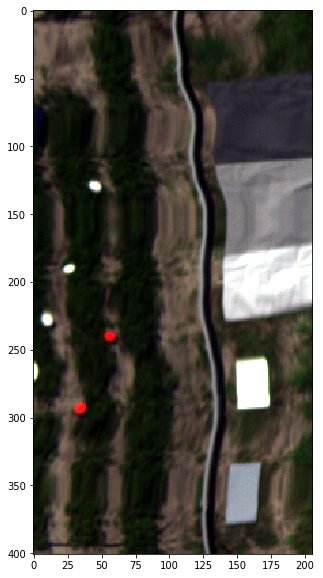

In [2]:
# Load the image
# Note: Image will have georeferencing error because it does gone through georeferencing yet which is normally done after reflectance.
imgFile = rasterio.open('img_radiance', 'r')

# Loading Metadata Data
data_anc = np.load('img_metadata.npz')
print('Ancillary data associated with this file: ' + str(data_anc.files))

# Set some of the variables from the ancillary data
wave = data_anc['wavelengths']
rgb_index = data_anc['rgb_index']
rgb_image = data_anc['rgb_image']

# Display Red/Green/Blue or true color image
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)

Text(0.5, 1.0, 'Band 30 or Wavelength 465.679993 nm')

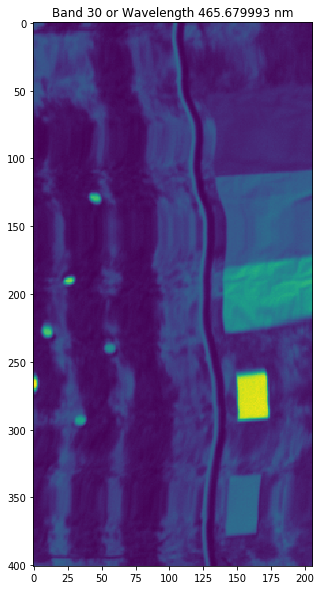

In [4]:
# Display Gray Scale image of a single band in hyperspectral image
imgData = imgFile.read(indexes=100)
plt.figure(figsize=(10,10))
plt.imshow(np.squeeze(imgData))
plt.title('Band 30 or Wavelength ' + str(wave[30]) + ' nm')

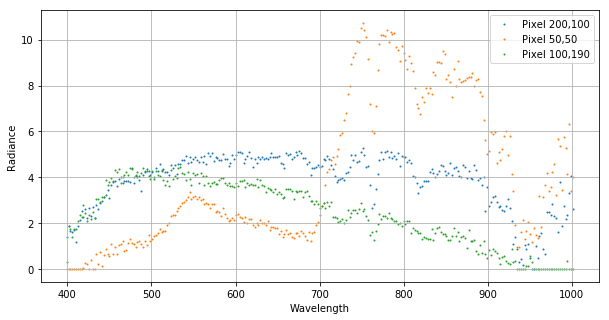

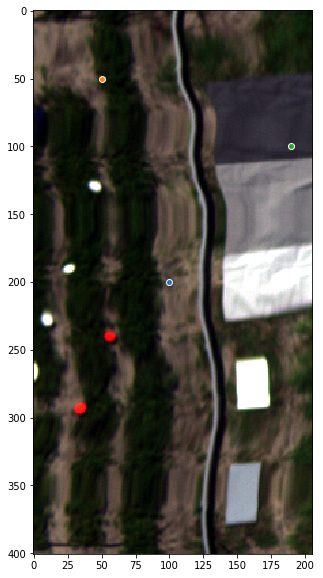

In [5]:
# Plot some pixels from image
x = [200, 50, 100]
y = [100, 50, 190]

# Loop through spectra to plot
plt.figure(figsize=(10,5))
text = []
for i in range(0,len(x)):
    window = ((x[i], x[i] + 1), (y[i], y[i] + 1))
    data = imgFile.read(window=window)  # Extract spectra from image
    pixel = np.transpose(data[:, 0, 0])
    text.append('Pixel ' + str(x[i]) + ',' + str(y[i]))
    plt.scatter(wave,pixel, s=1)
plt.legend(text)
plt.ylabel('Radiance')
plt.xlabel('Wavelength')
plt.grid(b=1)

# Look at the scatter plots of the spectra
plt.figure(figsize=(10,10)) #
plt.imshow(rgb_image)
for i in range(0,len(x)):
    plt.scatter(y[i],x[i], edgecolors='w')

**Next Steps**  
Across platforms, remote sensing instruments measure radiance or the amount of energy emitted, reflected, or transmitted from the earth’s surface. This energy is generally solar radiation from the sun that enters the earth’s atmosphere, interacts with the surface of the earth, and is reflected through the atmosphere to be measured by a sensor. The solar radiation on the sun-surface-sensor path in the visible and near-IR spectral regions (350 – 2500 nm) is subject to absorption and scattering by atmospheric gases and aerosols. These atmospheric conditions cause hyperspectral imaging data to contain atmospheric effects. In order to use hyperspectral imaging data for quantitative remote sensing of land surfaces and ocean color, the atmospheric effects must be removed. Therefore, to study surface properties using imaging spectrometer data, accurate removal of atmospheric absorption and scattering effects is required. This process, called atmospheric correction, is essential to convert radiances measured by the sensors to reflectances of surface materials. Since the mid-1980s, atmospheric correction algorithms have evolved from the empirical line approach to rigorous radiative transfer modeling approaches.

We are going to explore two methods for doing atmospheric correction:

1. Empirical Line
2. Radiative Transfer Model (RTM)

Note: If you are an atmopsheric scientist you would actually want to remove the surface and only retrieve the atmospheric components. This is useful for methane or other greenhouse gas studies. 



In [6]:
# Close Rasterio Instance
imgFile.close()